## Selection by Feature Shuffling

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.base import clone
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from feature_engine.selection import SelectByShuffling

In [2]:
# load dataset

breast_cancer = load_breast_cancer()
X = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)
y = breast_cancer.target

# Separate data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

X_train.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
293,11.85,17.46,75.54,432.7,0.08372,0.05642,0.026880,0.022800,0.1875,0.05715,...,13.06,25.75,84.35,517.8,0.1369,0.17580,0.13160,0.09140,0.3101,0.07007
332,11.22,19.86,71.94,387.3,0.10540,0.06779,0.005006,0.007583,0.1940,0.06028,...,11.98,25.78,76.91,436.1,0.1424,0.09669,0.01335,0.02022,0.3292,0.06522
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.144000,0.097910,0.1752,0.05533,...,23.69,38.25,155.00,1731.0,0.1166,0.19220,0.32150,0.16280,0.2572,0.06637
278,13.59,17.84,86.24,572.3,0.07948,0.04052,0.019970,0.012380,0.1573,0.05520,...,15.50,26.10,98.91,739.1,0.1050,0.07622,0.10600,0.05185,0.2335,0.06263
489,16.69,20.20,107.10,857.6,0.07497,0.07112,0.036490,0.023070,0.1846,0.05325,...,19.18,26.56,127.30,1084.0,0.1009,0.29200,0.24770,0.08737,0.4677,0.07623


In [3]:
# the ML model for which we want to select features

rf = RandomForestClassifier(
    n_estimators=10,
    random_state=2909,
)

## Feature-engine

In [4]:
sel = SelectByShuffling(
    estimator=rf, # the ML model
    scoring='roc_auc', # the metric to evaluate
    threshold=0,# the maximum performance drop allowed to select the feature
    cv=3, # cross validation
    random_state=1 # seed
)

sel.fit(X_train, y_train)

SelectByShuffling(estimator=RandomForestClassifier(n_estimators=10,
                                                   random_state=2909),
                  random_state=1, threshold=0)

In [5]:
# performance of model trained with all features

sel.initial_model_performance_

0.9822274044237158

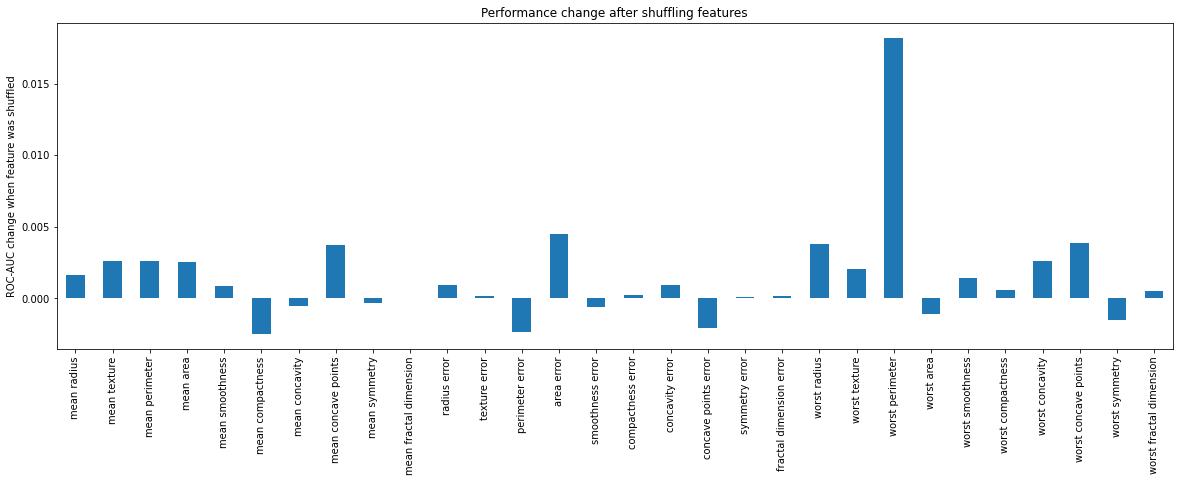

In [6]:
# Changes in performance after shuffling each feature

pd.Series(sel.performance_drifts_).plot.bar(figsize=(20,6))
plt.title('Performance change after shuffling features')
plt.ylabel('ROC-AUC change when feature was shuffled')
plt.show()

In [7]:
# the features to remove

sel.features_to_drop_

['mean smoothness',
 'mean compactness',
 'mean concavity',
 'mean symmetry',
 'mean fractal dimension',
 'radius error',
 'texture error',
 'perimeter error',
 'smoothness error',
 'compactness error',
 'concavity error',
 'concave points error',
 'symmetry error',
 'fractal dimension error',
 'worst area',
 'worst compactness',
 'worst symmetry',
 'worst fractal dimension']

In [8]:
# the selected features

(pd.Series(sel.performance_drifts_)>0).index

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension'],
      dtype='object')

In [9]:
# reduce dataset

X_train_t = sel.transform(X_train)
X_test_t = sel.transform(X_test)

X_test_t.head()

,mean radius,mean texture,mean perimeter,mean area,mean concave points,area error,worst radius,worst texture,worst perimeter,worst smoothness,worst concavity,worst concave points
512,13.40,20.52,88.64,556.7,0.08172,33.67,16.41,29.66,113.30,0.15740,0.51060,0.20510
457,13.21,25.25,84.10,537.9,0.02068,17.58,14.35,34.23,91.29,0.12890,0.13900,0.06005
439,14.02,15.66,89.59,606.5,0.02652,19.25,14.91,19.31,96.53,0.10340,0.06260,0.08216
298,14.26,18.17,91.22,633.1,0.01374,20.56,16.22,25.26,105.80,0.09445,0.15650,0.07530
37,13.03,18.42,82.61,523.8,0.02923,14.16,13.30,22.81,84.46,0.09701,0.04833,0.05013


## Manual

In [10]:
# train model using all features
rf.fit(X_train, y_train)

# print roc-auc in train and testing sets
print('train auc score: ',
      roc_auc_score(y_train, (rf.predict_proba(X_train.fillna(0)))[:, 1]))
print('test auc score: ',
      roc_auc_score(y_test, (rf.predict_proba(X_test.fillna(0)))[:, 1]))

train auc score:  0.9998822226933315
test auc score:  0.9908805031446541


In [11]:
# train roc-auc: using all the features
train_roc = roc_auc_score(y_train, (rf.predict_proba(X_train))[:, 1])

# list to capture the performance shift
performance_shift = []

for feature in X_train.columns:

    X_train_c = X_train.copy()

    # shuffle individual feature
    shuffle = X_train_c[feature].sample(frac=1, random_state=10)
    shuffle.index = X_train_c.index
    X_train_c[feature] = shuffle

    # make prediction with shuffled feature and calculate roc-auc
    shuff_roc = roc_auc_score(y_train, rf.predict_proba(X_train_c)[:, 1])
    
    # calculate performance change
    drift = train_roc - shuff_roc

    # save the drop in roc-auc
    performance_shift.append(drift)

In [12]:
# list of performance changes

performance_shift

[0.0,
 0.0002826655360045338,
 -0.00010599957600176957,
 7.06663840011057e-05,
 2.35554613337019e-05,
 1.177773066685095e-05,
 0.0002591100746708319,
 0.0017313264080277557,
 1.177773066685095e-05,
 0.0,
 5.888865333425475e-05,
 1.177773066685095e-05,
 0.00020022142133657717,
 7.06663840011057e-05,
 -4.71109226674038e-05,
 2.35554613337019e-05,
 0.00010599957600165855,
 4.71109226674038e-05,
 1.177773066685095e-05,
 4.71109226674038e-05,
 0.00012955503733547147,
 0.0004004428426730433,
 0.007290415282783402,
 1.177773066685095e-05,
 0.00012955503733547147,
 0.0,
 0.0005299978800085148,
 0.0004004428426730433,
 7.06663840011057e-05,
 0.0]

In [13]:
# transform the list into a pandas Series

feature_importance = pd.Series(
    performance_shift, index=X_train.columns).sort_values(ascending=False)

feature_importance.head()

worst perimeter         0.007290
mean concave points     0.001731
worst concavity         0.000530
worst concave points    0.000400
worst texture           0.000400
dtype: float64

In [14]:
# number of features that cause a drop in performance
# when shuffled

feature_importance[feature_importance>0].shape[0]

24

In [15]:
# print important features

feature_importance[feature_importance>0].index

Index(['worst perimeter', 'mean concave points', 'worst concavity',
       'worst concave points', 'worst texture', 'mean texture',
       'mean concavity', 'perimeter error', 'worst radius', 'worst smoothness',
       'concavity error', 'area error', 'mean area', 'worst symmetry',
       'radius error', 'concave points error', 'fractal dimension error',
       'mean smoothness', 'compactness error', 'texture error',
       'mean symmetry', 'mean compactness', 'symmetry error', 'worst area'],
      dtype='object')

In [16]:
# selected features
selected_features = feature_importance[feature_importance > 0].index

# train random forests using the selected features
rf = clone(rf)
rf.fit(X_train[selected_features], y_train)

# print roc-auc in train and testing sets
print(
    'train auc score: ',
    roc_auc_score(y_train, (rf.predict_proba(X_train[selected_features]))[:,
                                                                          1]))
print(
    'test auc score: ',
    roc_auc_score(y_test, (rf.predict_proba(X_test[selected_features]))[:, 1]))

train auc score:  0.9999882222693333
test auc score:  0.9959119496855346
